In [1]:
%load_ext autoreload

In [8]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_data_class, get_optimal_VAR_results, get_result_path, load, save

In [3]:
session = 'Mary-Anesthesia-20160809-01'
# session = 'Mary-Anesthesia-20170203-02'

## Load Neural Data

In [4]:
all_data_dir = "/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(session, all_data_dir)

In [5]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 4.35 seconds)


## Load Results

In [11]:
VAR_results = get_optimal_VAR_results(session, data_class, session_info)

Loading file /om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR/Mary-Anesthesia-20160809-01_selected_windows_phases_10_steps
Now attempting to load area 7b with window 5
Now attempting to load area 7b with window 8.5
Now attempting to load area CPB with window 8.5
Now attempting to load area FEF with window 4
Now attempting to load area CPB with window 6.5
Now attempting to load area all with window 6.5
Now attempting to load area vlPFC with window 6.5
Now attempting to load area 7b with window 7
Now attempting to load area vlPFC with window 7
Now attempting to load area CPB with window 10
Now attempting to load area FEF with window 8
Now attempting to load area all with window 8
Now attempting to load area FEF with window 5.5
Now attempting to load area all with window 9.5


In [12]:
VAR = VAR_results['all']

## Compute Matrix Norms

In [13]:
areas = np.unique(electrode_info['area'])

In [14]:
matrix_norms = {}
iterator = tqdm(total = len(areas)*len(areas))
for area1 in areas:
    for area2 in areas:
#         print(f"{area1} --> {area2}")
        matrix_norms[(area1, area2)] = np.zeros(len(VAR))
        area1_inds = np.where(electrode_info['area'] == area1)[0]
        area2_inds = np.where(electrode_info['area'] == area2)[0]
        
        for i in range(len(VAR)):
            A_mat = VAR.A_mat.iloc[i]
            matrix_norms[(area1, area2)][i] = np.linalg.norm(A_mat[area2_inds, :][:, area1_inds], ord=2)
    
        iterator.update()
iterator.close()

  0%|          | 0/16 [00:00<?, ?it/s]

## Plot

In [17]:
VAR.start_time

0         0.0
1         6.5
2        13.0
3        19.5
4        26.0
        ...  
898    6992.0
899    7001.5
900    7011.0
901    7020.5
902    7030.0
Name: start_time, Length: 903, dtype: float64

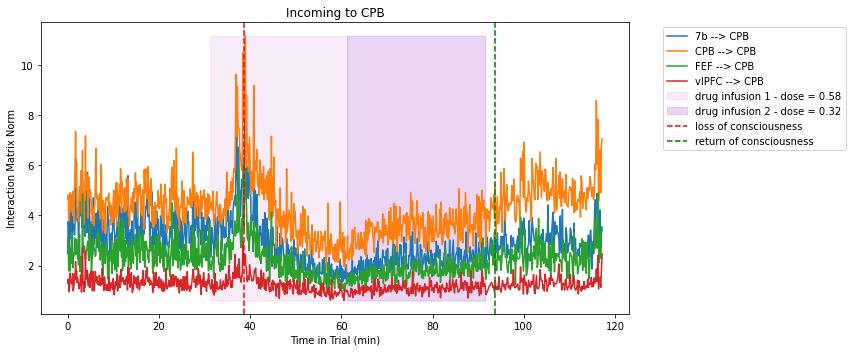

In [21]:
rows = 1
cols = 1

fig, axs = plt.subplots(rows, cols, figsize=(12, 5))

t = VAR.start_time/60
for i, area2 in enumerate(areas):
    if area2 in ['CPB']:
        if cols > 1 and rows > 1:
            ax = axs[int(i/1)][i % 1]
        elif cols == 1 and rows == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.set_title(f"Incoming to {area2}")
        ax.set_xlabel('Time in Trial (min)')
        ax.set_ylabel('Interaction Matrix Norm')
        min_val = np.Inf
        max_val = -np.Inf
        
        offset = 0
        for area1 in areas:
#             if area1 in ['vlPFC', 'CPB'] and area1 != area2:
            norms = matrix_norms[(area1, area2)]
            ax.plot(t, norms + offset, label=f"{area1} --> {area2}")
#             offset += norms.max()*1.15
            if norms.min() < min_val:
                min_val = norms.min()
            if norms.max() + offset > max_val:
                max_val = norms.max() + offset


        ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0])/60, 
                                        min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
        ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1])/60, 
                                min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

        ax.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
        ax.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
plt.legend(bbox_to_anchor=(1.05,1))  
plt.tight_layout()